In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [15]:

SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [16]:

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


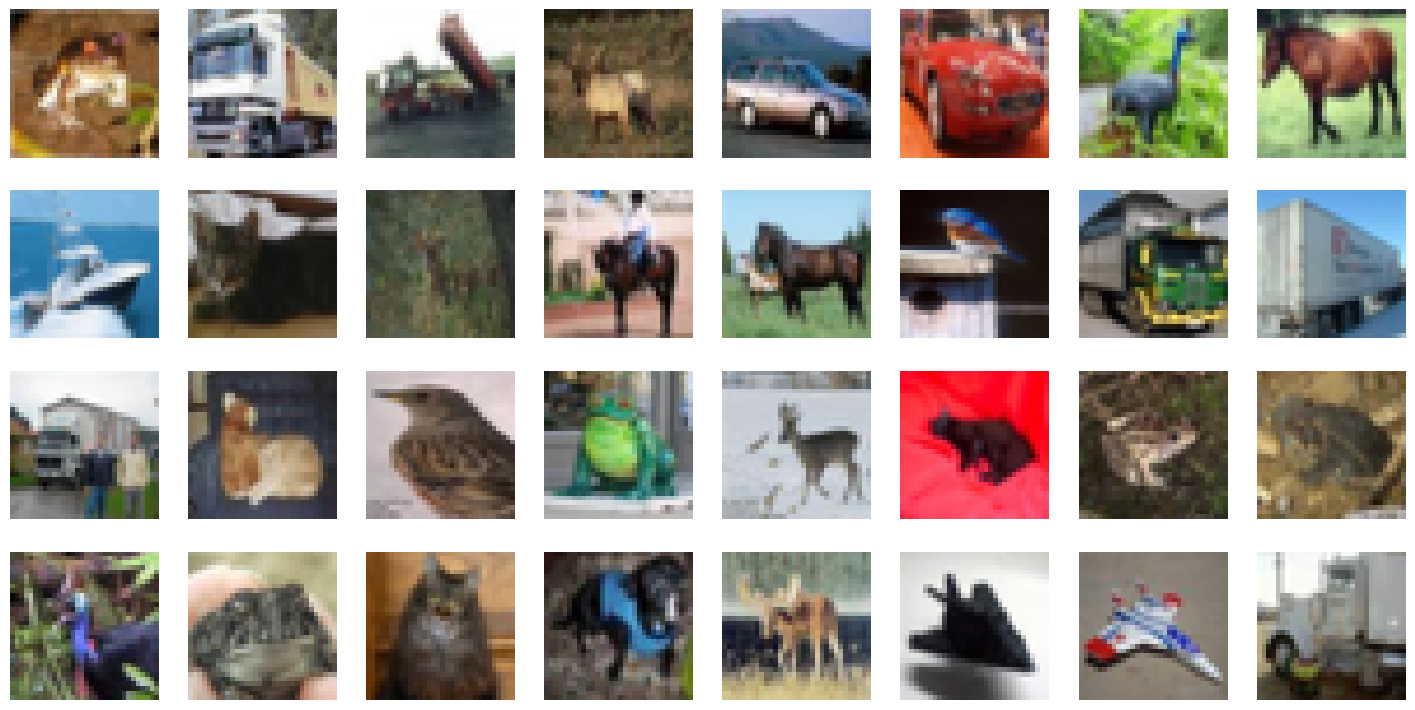

In [17]:
plt.figure(figsize=(18, 9))

num_rows = 4
num_cols = 8

# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    plt.axis("off")

In [18]:

# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])

# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[0])

Original (integer) label for the first training sample:  [6]
After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [19]:

@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 21
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

In [20]:
def cnn_model(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [21]:
# Create the model.
model = cnn_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                 

In [23]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
             )


In [24]:

history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_split=.3,
                   )

Epoch 1/21
137/137 [==============================] - 252s 2s/step - loss: 2.1228 - accuracy: 0.2298 - val_loss: 1.8997 - val_accuracy: 0.2854
Epoch 2/21
137/137 [==============================] - 246s 2s/step - loss: 1.7467 - accuracy: 0.3684 - val_loss: 1.5622 - val_accuracy: 0.4282
Epoch 3/21
137/137 [==============================] - 258s 2s/step - loss: 1.5056 - accuracy: 0.4559 - val_loss: 1.3534 - val_accuracy: 0.5047
Epoch 4/21
137/137 [==============================] - 265s 2s/step - loss: 1.3292 - accuracy: 0.5229 - val_loss: 1.2784 - val_accuracy: 0.5381
Epoch 5/21
137/137 [==============================] - 261s 2s/step - loss: 1.1837 - accuracy: 0.5765 - val_loss: 1.2700 - val_accuracy: 0.5506
Epoch 6/21
137/137 [==============================] - 250s 2s/step - loss: 1.0559 - accuracy: 0.6237 - val_loss: 1.0935 - val_accuracy: 0.6115
Epoch 7/21
137/137 [==============================] - 262s 2s/step - loss: 0.9449 - accuracy: 0.6676 - val_loss: 0.9794 - val_accuracy: 0.6594

In [25]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

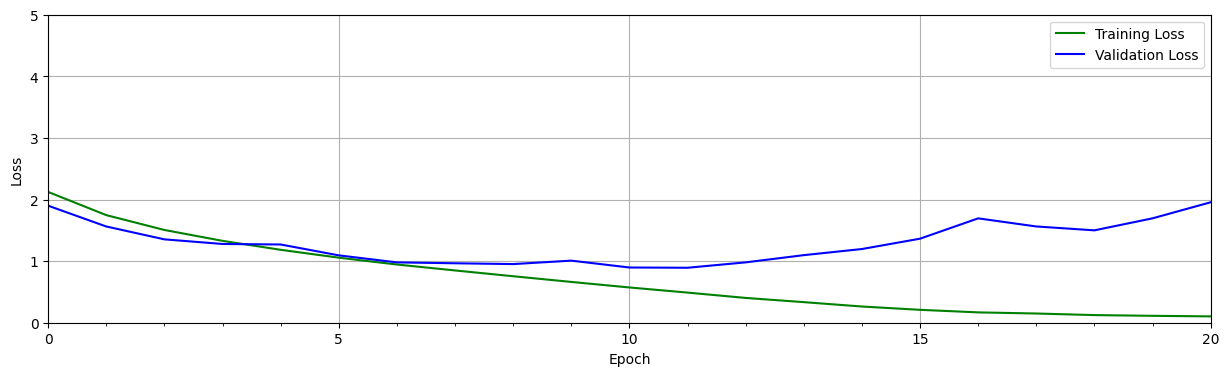

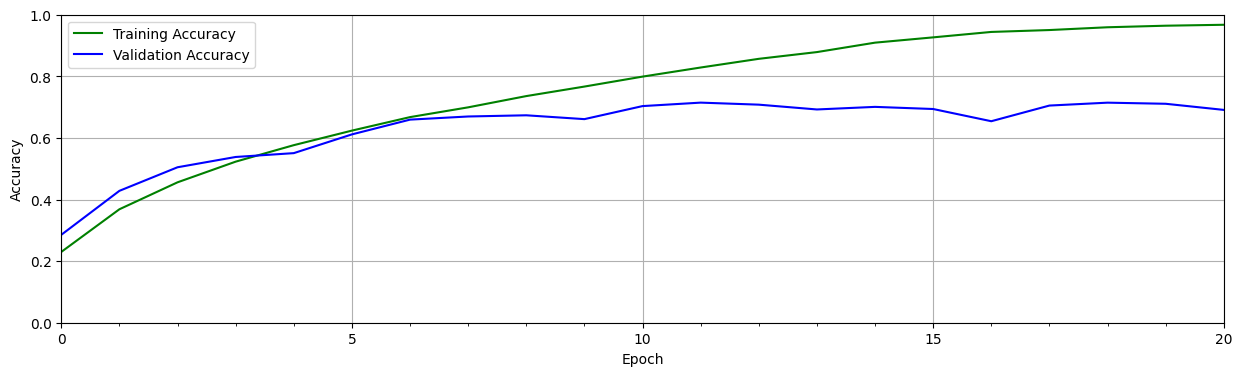

In [26]:

# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [27]:
def cnn_model_dropout(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [28]:
# Create the model.
model_dropout = cnn_model_dropout()
model_dropout.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [29]:

model_dropout.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'],
                     )

In [30]:

history = model_dropout.fit(X_train,
                            y_train,
                            batch_size=TrainingConfig.BATCH_SIZE,
                            epochs=TrainingConfig.EPOCHS,
                            verbose=1,
                            validation_split=.3,
                           )

Epoch 1/21
137/137 [==============================] - 261s 2s/step - loss: 2.1564 - accuracy: 0.2079 - val_loss: 1.8532 - val_accuracy: 0.3262
Epoch 2/21
137/137 [==============================] - 259s 2s/step - loss: 1.8608 - accuracy: 0.3230 - val_loss: 1.6470 - val_accuracy: 0.3912
Epoch 3/21
137/137 [==============================] - 250s 2s/step - loss: 1.6607 - accuracy: 0.3983 - val_loss: 1.4819 - val_accuracy: 0.4593
Epoch 4/21
137/137 [==============================] - 257s 2s/step - loss: 1.5022 - accuracy: 0.4594 - val_loss: 1.3843 - val_accuracy: 0.4981
Epoch 5/21
137/137 [==============================] - 254s 2s/step - loss: 1.3858 - accuracy: 0.5015 - val_loss: 1.2718 - val_accuracy: 0.5304
Epoch 6/21
137/137 [==============================] - 262s 2s/step - loss: 1.2752 - accuracy: 0.5414 - val_loss: 1.2410 - val_accuracy: 0.5494
Epoch 7/21
137/137 [==============================] - 256s 2s/step - loss: 1.1878 - accuracy: 0.5764 - val_loss: 1.1065 - val_accuracy: 0.6093

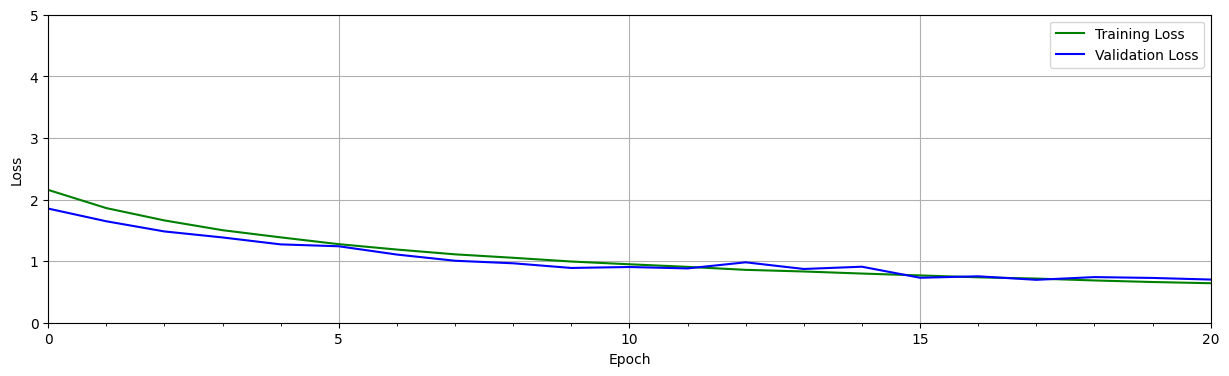

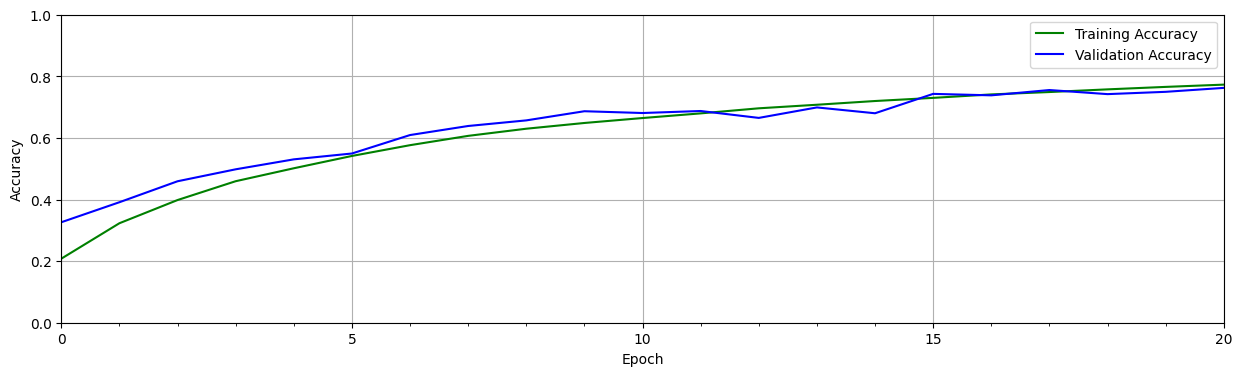

In [31]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [32]:

# Using the save() method, the model will be saved to the file system in the 'SavedModel' format.
model_dropout.save('model_dropout')

In [33]:
from tensorflow.keras import models
reloaded_model_dropout = models.load_model('model_dropout')

In [34]:

test_loss, test_acc = reloaded_model_dropout.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 [==============================] - 18s 56ms/step - loss: 0.7216 - accuracy: 0.7542
Test accuracy: 75.420


In [35]:
def evaluate_model(dataset, model):

    class_names = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck' ]
    num_rows = 3
    num_cols = 6

    # Retrieve a number of images from the dataset.
    data_batch = dataset[0:num_rows*num_cols]

    # Get predictions from model.
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])


        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={'fontsize':13})

        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')

        acc = num_matches/(idx+1)
    print("Prediction accuracy: ", int(100*acc)/100)

    return

1/1 [==============================] - 0s 215ms/step
Prediction accuracy:  0.83


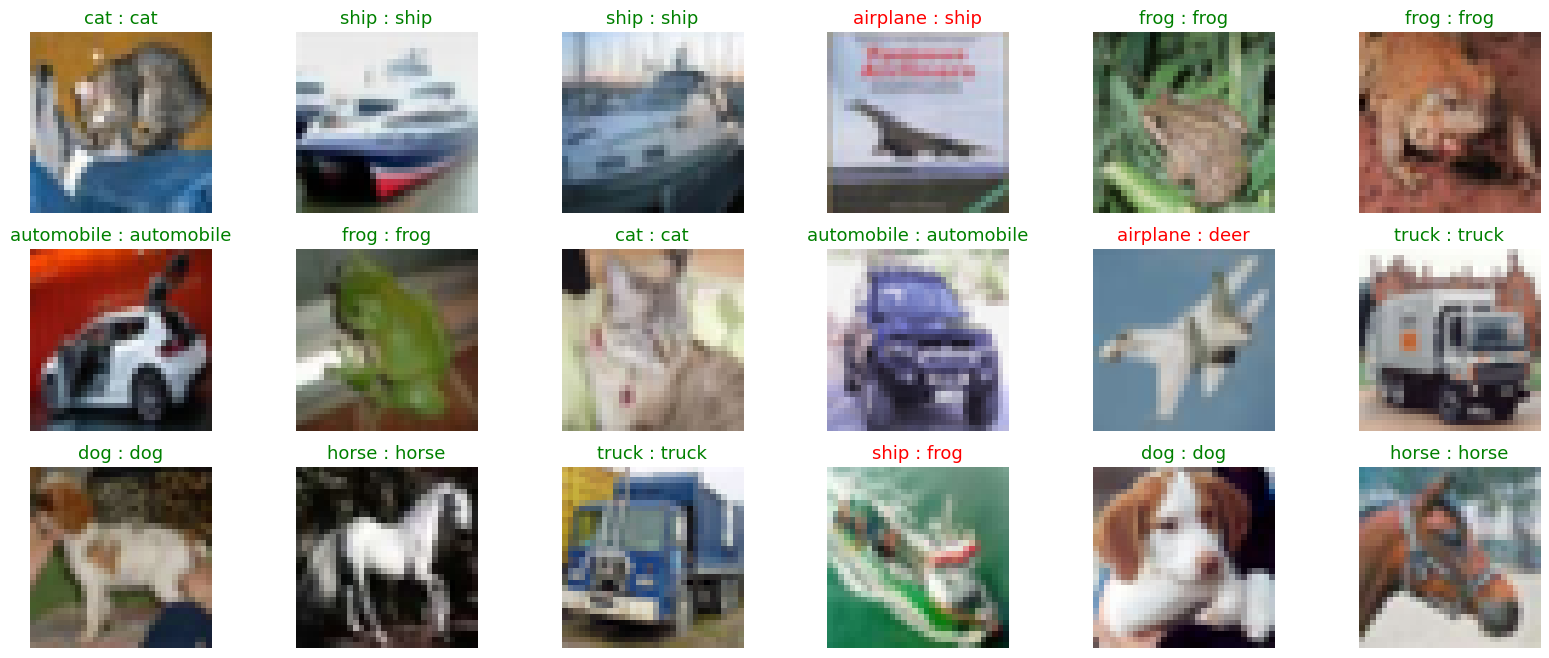

In [36]:
evaluate_model(X_test, reloaded_model_dropout)

In [37]:

# Generate predictions for the test dataset.
predictions = reloaded_model_dropout.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 16s 53ms/step


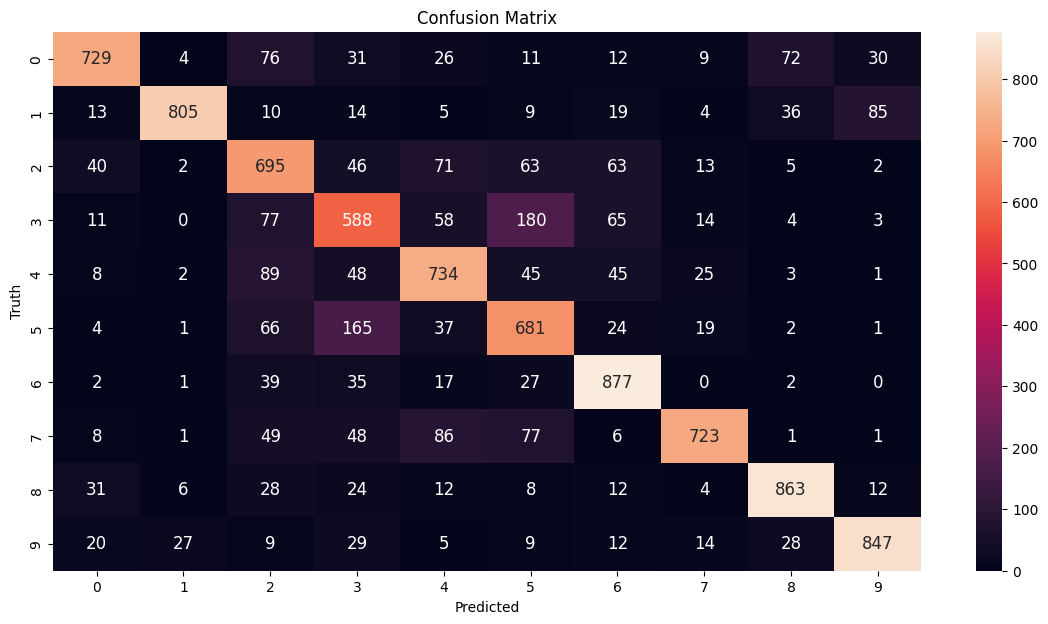

In [38]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[14, 7])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()